In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
%matplotlib inline
sns.set()
# Scipy Optimization Algorithm is used to find the optimal parameters
import scipy.optimize as opt
# Scipy is needed to load a MATLAB digit dataset
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy import linalg
import matplotlib
#Sklearn train_test_split to split a set on train and test 
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split   # for old sclearn
from sklearn.metrics import average_precision_score
from IPython.display import Image, display

## Anomaly detection

In [77]:
data1 = loadmat('ex8data1')  # First example Dataset for anomaly detection
data2 = loadmat('ex8data2')  # Second example Dataset for anomaly detection

In [78]:
X1 = np.array(data1['X'])
Y1 = np.array(data1['yval'])
X2 = np.array(data2['X'])
Y2 = np.array(data2['yval'])
X1.shape, X2.shape

((307, 2), (1000, 11))

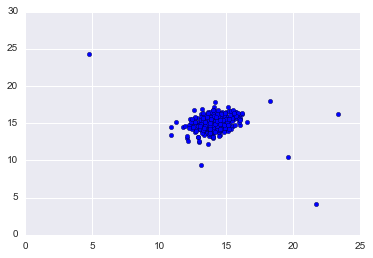

In [79]:
plt.scatter(X1[:,0],X1[:,1])

## Gaussian Distribution

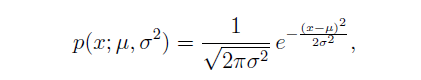

In [80]:
display(Image(filename='week9_1.PNG', embed=True, width=500))

<img src='week9_1.PNG',alt="Drawing" style="width: 400px;"/>

In [81]:
# Function to define mean and square deviation
def estimGaus(x):
    mean = x.sum(axis=0)/len(x)
    sigma2 = (np.square(X1 - mean)).sum(axis = 0)/len(x)
    return mean, sigma2
mean, sigma2 = estimGaus(X1)

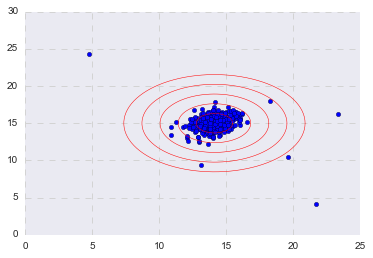

In [82]:
u=mean[0]    #x-position of the center
v=mean[1]   #y-position of the center

for n in range (1,6):
    a=n*sigma2[0]**0.5     #radius on the x-axis
    b=n*sigma2[1]**0.5   #radius on the y-axis               
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot( u+a*np.cos(t) , v+b*np.sin(t), color = 'red',linewidth = 0.5)
    plt.grid(color='lightgray',linestyle='--')
plt.scatter(X1[:,0],X1[:,1])   
plt.show()

In [83]:
# function for probability calculation
def prob(x):
    mean, sigma2 = estimGaus(x)
    p = (2*np.pi*sigma2)**0.5 * np.exp(-(x-mean)**2/(2*sigma2))
    prob=p[:,0]*p[:,1]
    return prob

In [84]:
Y = prob(X1)
Y=np.array([i<0.9 for i in Y])
Y = Y.astype(int)  #convert True-False array to (0,1)
Y.shape

(307,)

In [85]:
xn_train, xn_test, yn_train, yn_test = train_test_split(X1, Y, test_size=0.7, random_state=40)
xn_train.shape, xn_test.shape, yn_train.shape, yn_test.shape

((92, 2), (215, 2), (92,), (215,))

In [86]:
e = 0.375
Y_cv = prob(xn_test)
Y_cv=np.array([i<e for i in Y_cv])
Y_cv = Y_cv.astype(int)  #convert True-False array to (0,1)

In [87]:
average_precision = average_precision_score(yn_test, Y_cv)
print(average_precision)

0.7926910299


In [88]:
# Now lets make all above as a funciton, e - np.array with thresholds which we want to check
def threshold(e, x):
    average_precision = []
    for i in e:
        Y = prob(x)
        Y=np.array([j<i for j in Y])
        Y = Y.astype(int)  #convert True-False array to (0,1)
        xn_train, xn_test, yn_train, yn_test = train_test_split(x, Y, test_size=0.7, random_state=40)
        Y_cv = prob(xn_test)
        Y_cv=np.array([j<i for j in Y_cv])
        Y_cv = Y_cv.astype(int)  #convert True-False array to (0,1)
        average_precision.append(average_precision_score(yn_test, Y_cv))
    return average_precision

In [89]:
e=np.linspace(0.05,1,20)
g=threshold(e, X1)
print('max_precision   epsilon= ',e[np.argmax(g, axis=None)], 'precision =', g[np.argmax(g, axis=None)], '\nmin_precision   epsilon= ' 
      ,e[np.argmin(g, axis=None)], 'precision =',g[np.argmin(g, axis=None)])


max_precision   epsilon=  0.1 precision = 1.0 
min_precision   epsilon=  0.8 precision = 0.7926910299


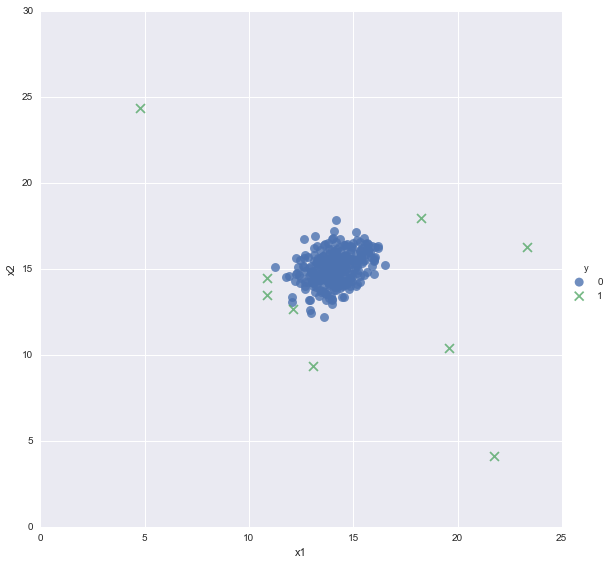

In [90]:
#Show the worst case with epsilon = 0.8

e = 0.8
Y = prob(X1)
Y=np.array([i<e for i in Y])
Y = Y.astype(int)  #convert True-False array to (0,1)
Y.shape

d2=pd.DataFrame({'x1' : X1[:,0],'x2':X1[:,1],'y':Y})
sns.lmplot(x='x1', y='x2', hue='y', data=d2, fit_reg=False, markers=["o", "x"], size=8, scatter_kws={"s": 80})

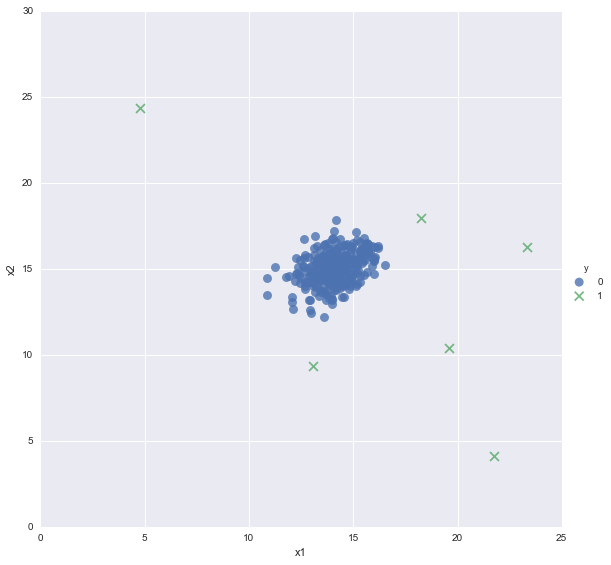

In [91]:
#Show the best case with epsilon = 0.1

e = 0.1
Y = prob(X1)
Y=np.array([i<e for i in Y])
Y = Y.astype(int)  #convert True-False array to (0,1)
Y.shape

d2=pd.DataFrame({'x1' : X1[:,0],'x2':X1[:,1],'y':Y})
sns.lmplot(x='x1', y='x2', hue='y', data=d2, fit_reg=False, markers=["o", "x"], size=8, scatter_kws={"s": 80})

## Recommender Systems
#### In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.2 This dataset consists of ratings on a scale of 1 to 5. The dataset has nu = 943 users, and nm = 1682 movies.

The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with R(i; j) = 0. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [92]:
data3 = loadmat('ex8_movieParams')  
data4 = loadmat('ex8_movies') 

In [93]:
R = np.array(data4['R'])  # r vector
Y = np.array(data4['Y'])  # movie rating
R.shape, Y.shape   # 1682 movies and 943 users

((1682, 943), (1682, 943))

In [94]:
Theta = np.array(data3['Theta'])  # theta for each user
X = np.array(data3['X'])   # feature for each movie
Theta.shape, X.shape  # 1682 movies and 943 users

((943, 10), (1682, 10))

In [95]:
params = np.concatenate((Theta.ravel(), X.ravel()), axis=0)

In [96]:
Theta = params[:Theta.shape[0]*Theta.shape[1]].reshape(Theta.shape)

In [97]:
Theta.shape

(943, 10)

In [98]:
Theta.shape

(943, 10)

In [99]:
# Cost function. Cost function counts only values which are not zero (customer rated the movie)
users = Theta.shape[0]  
movies = X.shape[0]  
features = X.shape[1]
params = np.concatenate((Theta.ravel(), X.ravel()), axis=0)
def cofiCostFunc(params, R, Y, Theta, X):
    theta = params[:Theta.shape[0]*Theta.shape[1]].reshape(Theta.shape)
    x = params[Theta.shape[0]*Theta.shape[1]:].reshape(X.shape)
    #X = params[users:,:]
    #Theta = params[:users,:]
    cost = 0.5*R*(np.matmul(x,theta.T) - Y)**2
    cost = cost.sum()
    
    #gradient
    g = (np.matmul(x,theta.T) - Y)*R
    x_grad = np.matmul(g,theta)
    theta_grad = np.matmul(g.T,x)
    params_grad = np.concatenate((theta_grad.ravel(), x_grad.ravel()), axis=0)
    
    return cost, params_grad

In [100]:
# Test the cost function on the subset
users = 4  
movies = 5  
features = 3

X_sub = X[:movies, :features]  
Theta_sub = Theta[:users, :features]  
Y_sub = Y[:movies, :users]  
R_sub = R[:movies, :users]
params = np.concatenate((Theta_sub.ravel(), X_sub.ravel()), axis=0)
cost, grad = cofiCostFunc(params, R_sub, Y_sub, Theta_sub, X_sub)
print(cost)

22.2246037257


In [101]:
grad.shape

(27,)

In [102]:
X_sub.shape

(5, 3)

In [103]:
# Cost function with regularization
def cofiCostFunc_reg(params, R, Y,lamb, Theta, X):
    theta = params[:Theta.shape[0]*Theta.shape[1]].reshape(Theta.shape)
    x = params[Theta.shape[0]*Theta.shape[1]:].reshape(X.shape)
    cost = 0.5*R*(np.matmul(x,theta.T) - Y)**2
    cost = cost.sum()+ lamb/2*(theta**2).sum()+ lamb/2*(X**2).sum()
    
    #gradient
    g = (np.matmul(x,theta.T) - Y)*R
    x_grad = np.matmul(g,theta) + lamb*X
    theta_grad = np.matmul(g.T,x) + lamb*theta
    params_grad = np.concatenate((theta_grad.ravel(), x_grad.ravel()), axis=0)
    
    return cost, params_grad

In [104]:
# Check the grad_reg function, the rezult is same as in the Exersise.
cost, grad = cofiCostFunc_reg(params, R_sub, Y_sub, 1.5, Theta_sub, X_sub)
print(cost)

31.3440562443


In [105]:
users = Theta.shape[0]  
movies = X.shape[0]  
features = X.shape[1]
params = np.concatenate((Theta, X), axis=0)
params.shape

(2625, 10)

In [106]:
fmin = opt.minimize(fun=cofiCostFunc_reg,  x0=params, args=(R, Y, 1.5, Theta, X),  
                method='TNC', jac=True, options={'maxiter': 250})

In [107]:
fmin.x.shape

(26250,)

In [108]:
fmin

     fun: 31431.471376730155
     jac: array([ 1.8169779 , -2.77060901,  1.63999332, ...,  0.01192596,
       -0.11456165,  0.00938922])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 6
  status: 3
 success: False
       x: array([ 0.4667524 , -1.54553608,  0.55021634, ...,  0.85698651,
       -0.14849002, -0.05991223])

In [109]:
# It would be better to delete Theta and X from Cost function arguments... they are here only for previous check with 4 users
# and 5 movies
cost, params_grad = cofiCostFunc_reg(fmin.x, R, Y,1.5, Theta, X)
print(cost)

31431.4713767


In [110]:
theta = fmin.x[:Theta.shape[0]*Theta.shape[1]].reshape(Theta.shape)
x = fmin.x[Theta.shape[0]*Theta.shape[1]:].reshape(X.shape)

In [111]:
theta.shape, x.shape

((943, 10), (1682, 10))

In [112]:
with open ('movie_ids.txt') as file:
    f=file.read()
    file.close()
f = f.split('\n')
f=np.array(f[:-1])


In [113]:
f.shape

(1682,)

In [114]:
# Predict the movies rating
y_pred = np.matmul(X,theta.T)
y_pred.shape

(1682, 943)

In [115]:
# Find the 5 closest movies for recommendation
movie = x[556,:]
distances = np.sqrt(((x - movie)**2).sum(axis=1))

In [116]:
dist = pd.DataFrame({'Movie':f, 'Distance':distances})
dist.head()

,Distance,Movie
0,2.061722,1 Toy Story (1995)
1,1.967614,2 GoldenEye (1995)
2,2.481394,3 Four Rooms (1995)
3,2.370211,4 Get Shorty (1995)
4,1.644761,5 Copycat (1995)


In [117]:
dist.sort_values(by=['Distance'])
#below the recomendation List from closest to farest movies

,Distance,Movie
556,0.000000,557 Farinelli: il castrato (1994)
537,0.979931,538 Anastasia (1997)
64,1.015292,65 What's Eating Gilbert Grape (1993)
286,1.031849,287 Marvin's Room (1996)
978,1.069749,"979 Trigger Effect, The (1996)"
816,1.098186,817 Frisk (1995)
1240,1.165512,"1241 Van, The (1996)"
941,1.201459,942 What's Love Got to Do with It (1993)
844,1.210399,845 That Thing You Do! (1996)
924,1.226595,925 Unforgettable (1996)
